<a href="https://colab.research.google.com/github/ResistorCat/recsys-project/blob/main/model/DeepFM_Foodcom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
FLAG_DATASET_DL = True

# DeepFM para Recomendación de Recetas Food.com

## 1. Carga de datos y librerías

In [2]:
# Actualizar pip
%pip install --upgrade --quiet pip setuptools wheel
# Dependencias para graficar y manipular datos
%pip install --quiet pandas matplotlib tqdm seaborn ipywidgets
# Dependencias para leer archivos Parquet
%pip install --quiet pyarrow fastparquet
# Para predicción y deep learning
%pip install --quiet scikit-learn tensorflow keras tensorflow-addons
# Para métricas de recomendación
%pip install --quiet implicit

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importar librerías globales

# Suprimir warnings para output más limpio
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Manejo de datos y visualización
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import zipfile
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuración de TensorFlow para reducir warnings
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Detectar GPUs disponibles
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs físicas detectadas: {len(gpus)}")

# Crear directorios
PATH_DATASETS = "datasets"
PATH_DATASETS_FOODCOM = os.path.join(PATH_DATASETS, "foodcom")
os.makedirs(PATH_DATASETS, exist_ok=True)
print(f"Directorio de datasets creado: {PATH_DATASETS}")

2025-07-05 23:01:51.110534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-05 23:01:51.113947: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-05 23:01:51.123502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751770911.139085   64835 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751770911.143691   64835 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751770911.156367   64835 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

GPUs físicas detectadas: 0
Directorio de datasets creado: datasets


E0000 00:00:1751770912.507880   64835 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1751770912.510690   64835 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
PATH_FOODCOM_RECIPES = os.path.join(PATH_DATASETS_FOODCOM, "recipes.parquet")
PATH_FOODCOM_REVIEWS = os.path.join(PATH_DATASETS_FOODCOM, "reviews.parquet")

In [5]:
if FLAG_DATASET_DL:
    # Descargar "Recipes and Reviews" de Food.com
    os.system(
        f"curl -L -o {PATH_DATASETS_FOODCOM}.zip https://www.kaggle.com/api/v1/datasets/download/irkaal/foodcom-recipes-and-reviews"
    )

    # Cita: Dominio público (https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews)
    zip_path = PATH_DATASETS_FOODCOM + ".zip"

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(PATH_DATASETS_FOODCOM)

    # Eliminar el zip
    os.remove(f"{PATH_DATASETS_FOODCOM}.zip")

    print("✅ Archivos descomprimidos en:", PATH_DATASETS_FOODCOM)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  723M  100  723M    0     0   9.9M      0  0:01:12  0:01:12 --:--:-- 9651k
100  723M  100  723M    0     0   9.9M      0  0:01:12  0:01:12 --:--:-- 9651k


✅ Archivos descomprimidos en: datasets/foodcom


## 2. Preprocesamiento de datos

In [6]:
df_recipes = pd.read_parquet(PATH_FOODCOM_RECIPES)
df_reviews = pd.read_parquet(PATH_FOODCOM_REVIEWS)

# Convertir columnas
df_recipes["RecipeId"] = pd.to_numeric(
    df_recipes["RecipeId"], errors="coerce", downcast="integer"
)

# Eliminar filas NaN
df_recipes.dropna(inplace=True)
df_reviews.dropna(inplace=True)

# Renombrar columnas
def camel_to_snake(name):
    """Convert CamelCase to snake_case"""
    name = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", name)
    return re.sub("([a-z0-9])([A-Z])", r"\1_\2", name).lower()

# Rename df_recipes columns
recipes_column_mapping = {"RecipeId": "item_id", "AuthorId": "user_id"}

# Add snake_case mapping for all other columns
for col in df_recipes.columns:
    if col not in recipes_column_mapping:
        recipes_column_mapping[col] = camel_to_snake(col)

df_recipes.rename(columns=recipes_column_mapping, inplace=True)

# Rename df_reviews columns
reviews_column_mapping = {
    "RecipeId": "item_id",
    "AuthorId": "user_id",
    "Rating": "rating",
}

# Add snake_case mapping for all other columns
for col in df_reviews.columns:
    if col not in reviews_column_mapping:
        reviews_column_mapping[col] = camel_to_snake(col)

df_reviews.rename(columns=reviews_column_mapping, inplace=True)

print("✅ Columnas renombradas")
print("Columnas df_recipes:", list(df_recipes.columns))
print("Columnas df_reviews:", list(df_reviews.columns))

print("\n📊 Resumen de datos:")
print(f"Recetas: {len(df_recipes)}")
print(f"Reviews: {len(df_reviews)}")
print(f"Usuarios únicos: {df_reviews['user_id'].nunique()}")
print(f"Items únicos: {df_reviews['item_id'].nunique()}")

display(df_recipes.head(2))
display(df_reviews.head(2))

✅ Columnas renombradas
Columnas df_recipes: ['item_id', 'name', 'user_id', 'author_name', 'cook_time', 'prep_time', 'total_time', 'date_published', 'description', 'images', 'recipe_category', 'keywords', 'recipe_ingredient_quantities', 'recipe_ingredient_parts', 'aggregated_rating', 'review_count', 'calories', 'fat_content', 'saturated_fat_content', 'cholesterol_content', 'sodium_content', 'carbohydrate_content', 'fiber_content', 'sugar_content', 'protein_content', 'recipe_servings', 'recipe_yield', 'recipe_instructions']
Columnas df_reviews: ['review_id', 'item_id', 'user_id', 'author_name', 'rating', 'review', 'date_submitted', 'date_modified']

📊 Resumen de datos:
Recetas: 28648
Reviews: 1401982
Usuarios únicos: 271907
Items únicos: 271678


,item_id,name,user_id,author_name,cook_time,prep_time,total_time,date_published,description,images,...,saturated_fat_content,cholesterol_content,sodium_content,carbohydrate_content,fiber_content,sugar_content,protein_content,recipe_servings,recipe_yield,recipe_instructions
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03 14:54:00+00:00,This dish is best prepared a day in advance to...,[https://img.sndimg.com/food/image/upload/w_55...,...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"[Drain the tofu, carefully squeezing out exces..."
5,43,Best Blackbottom Pie,34879,Barefoot Beachcomber,PT2H,PT20M,PT2H20M,1999-08-21 10:35:00+00:00,Make and share this Best Blackbottom Pie recip...,[],...,10.9,94.3,267.6,58.0,1.8,42.5,7.0,8.0,1 9-inch pie,"[Graham Cracker Crust: In small bowl, combine ..."


,review_id,item_id,user_id,author_name,rating,review,date_submitted,date_modified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25 21:44:00+00:00,2000-01-25 21:44:00+00:00
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17 16:49:59+00:00,2001-10-17 16:49:59+00:00


In [7]:
# Análisis del dataset
print("📈 Estadísticas de reviews:")
print(df_reviews[['rating']].describe())

print("\n📈 Estadísticas de recetas (numéricas):")
numeric_cols = df_recipes.select_dtypes(include=[np.number]).columns
print(df_recipes[numeric_cols].describe())

print("\n📊 Distribución de ratings:")
print(df_reviews['rating'].value_counts().sort_index())

print("\n🔍 Sparsity del dataset:")
n_users = df_reviews['user_id'].nunique()
n_items = df_reviews['item_id'].nunique()
n_interactions = len(df_reviews)
sparsity = 1 - (n_interactions / (n_users * n_items))
print(f"Usuarios: {n_users}")
print(f"Items: {n_items}")
print(f"Interacciones: {n_interactions}")
print(f"Sparsity: {sparsity:.5f} ({sparsity*100:.4f}%)")

📈 Estadísticas de reviews:
             rating
count  1.401982e+06
mean   4.407951e+00
std    1.272012e+00
min    0.000000e+00
25%    4.000000e+00
50%    5.000000e+00
75%    5.000000e+00
max    5.000000e+00

📈 Estadísticas de recetas (numéricas):
             item_id       user_id  aggregated_rating  review_count  \
count   28648.000000  2.864800e+04       28648.000000  28648.000000   
mean   297214.726578  1.392019e+07           4.616029      4.885751   
std    137276.209243  1.597549e+08           0.693318     24.056908   
min        41.000000  2.700000e+01           1.000000      1.000000   
25%    195066.250000  1.666420e+05           4.500000      1.000000   
50%    324204.000000  3.590475e+05           5.000000      2.000000   
75%    402770.250000  7.796990e+05           5.000000      4.000000   
max    540899.000000  2.002451e+09           5.000000   2273.000000   

           calories   fat_content  saturated_fat_content  cholesterol_content  \
count  28648.000000  28648.00000

## 3. Implementación del modelo DeepFM

In [8]:
class FoodcomDataProcessor:
    """
    Utilidad para procesar datos de Food.com para DeepFM.
    """

    def __init__(
        self,
        min_ratings_per_user=5,
        min_ratings_per_item=5,
        rating_threshold=4.0,
        verbose=False,
    ):
        self.min_ratings_per_user = min_ratings_per_user
        self.min_ratings_per_item = min_ratings_per_item
        self.rating_threshold = rating_threshold
        self.verbose = verbose

        # Encoders
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        self.category_encoder = LabelEncoder()

        # Scalers para features numéricas
        self.numeric_scaler = StandardScaler()

        # Features numericas
        self.numeric_features = [
            "calories",
            "fat_content",
            "protein_content",
            "cholesterol_content",
            "sodium_content",
            "carbohydrate_content",
            "fiber_content",
            "sugar_content",
            "aggregated_rating",
        ]

    def _filter_data(self, df_reviews):
        """Filtrar datos por mínimo de ratings"""
        user_counts = df_reviews["user_id"].value_counts()
        item_counts = df_reviews["item_id"].value_counts()

        keep_users = user_counts[user_counts >= self.min_ratings_per_user].index
        keep_items = item_counts[item_counts >= self.min_ratings_per_item].index

        filtered_df = df_reviews[
            df_reviews["user_id"].isin(keep_users)
            & df_reviews["item_id"].isin(keep_items)
        ].copy()

        if self.verbose:
            print(f"Filtrado: {len(df_reviews)} -> {len(filtered_df)} interacciones")
            print(
                f"Usuarios: {df_reviews['user_id'].nunique()} -> {filtered_df['user_id'].nunique()}"
            )
            print(
                f"Items: {df_reviews['item_id'].nunique()} -> {filtered_df['item_id'].nunique()}"
            )

        return filtered_df

    def _create_features(self, df_reviews, df_recipes):
        """Crear features para DeepFM"""
        # Merge reviews con recipes para obtener metadata
        # Usar suffixes para evitar conflictos de columnas
        df = df_reviews.merge(
            df_recipes, on="item_id", how="left", suffixes=("", "_recipe")
        )

        if self.verbose:
            print(f"Columnas después del merge: {list(df.columns)}")

        # Features categóricas
        df["user_id_encoded"] = self.user_encoder.fit_transform(df["user_id"])
        df["item_id_encoded"] = self.item_encoder.fit_transform(df["item_id"])

        # Procesar categoría de receta
        df["recipe_category"] = df["recipe_category"].fillna("unknown")
        df["category_encoded"] = self.category_encoder.fit_transform(
            df["recipe_category"]
        )

        # Verificar que las columnas existan antes de usarlas
        available_numeric = []
        for col in self.numeric_features:
            if col in df.columns:
                available_numeric.append(col)
            else:
                if self.verbose:
                    print(
                        f"⚠️ Columna {col} no encontrada, se usará 0 como valor por defecto"
                    )
                df[col] = 0
                available_numeric.append(col)

        # Llenar valores NaN
        df[available_numeric] = df[available_numeric].fillna(0)

        # Normalizar features numéricas
        df[available_numeric] = self.numeric_scaler.fit_transform(df[available_numeric])

        # Features derivadas
        df["high_rating"] = (df["aggregated_rating"] > 0).astype(int)  # Ya normalizado
        df["high_protein"] = (df["protein_content"] > 0.5).astype(
            int
        )  # Umbral en escala normalizada
        df["low_fat"] = (df["fat_content"] < -0.5).astype(
            int
        )  # Umbral en escala normalizada
        df["low_calories"] = (df["calories"] < -0.5).astype(
            int
        )  # Umbral en escala normalizada
        df["low_sodium"] = (df["sodium_content"] < -0.5).astype(
            int
        )
        df["low_sugar"] = (df["sugar_content"] < -0.5).astype(
            int
        )
        df["high_fiber"] = (df["fiber_content"] > 0.5).astype(
            int
        )

        # Target binario (implicit feedback)
        df["label"] = (df["rating"] >= self.rating_threshold).astype(int)

        return df

    def prepare_data(self, df_reviews, df_recipes, test_size=0.2, random_state=42):
        """Preparar datos para entrenamiento"""
        # Filtrar datos
        df_reviews_filtered = self._filter_data(df_reviews)

        # Crear features
        df_processed = self._create_features(df_reviews_filtered, df_recipes)

        # Definir features para el modelo
        categorical_features = [
            "user_id_encoded",
            "item_id_encoded",
            "category_encoded",
        ]
        numerical_features = self.numeric_features.copy()
        derived_features = ["high_rating", "high_protein", "low_fat"]

        feature_columns = categorical_features + numerical_features + derived_features

        X = df_processed[feature_columns]
        y = df_processed["label"]

        # Split train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Información de vocabularios
        self.vocab_sizes = {
            "user_id": len(self.user_encoder.classes_),
            "item_id": len(self.item_encoder.classes_),
            "category": len(self.category_encoder.classes_),
        }

        self.feature_info = {
            "categorical": categorical_features,
            "numerical": numerical_features,
            "derived": derived_features,
            "all": feature_columns,
        }

        if self.verbose:
            print(f"✅ Datos preparados:")
            print(f"Train: {len(X_train)}, Test: {len(X_test)}")
            print(f"Vocabularios: {self.vocab_sizes}")
            print(f"Features: {len(feature_columns)}")
            print(f"Distribución labels train: {y_train.value_counts().to_dict()}")

        return X_train, X_test, y_train, y_test


# Ejemplo de uso
processor = FoodcomDataProcessor(
    min_ratings_per_user=10, min_ratings_per_item=10, rating_threshold=4.0, verbose=True
)

X_train, X_test, y_train, y_test = processor.prepare_data(df_reviews, df_recipes)
print("✅ Datos procesados para DeepFM")

Filtrado: 1401982 -> 530589 interacciones
Usuarios: 271907 -> 15146
Items: 271678 -> 26553
Columnas después del merge: ['review_id', 'item_id', 'user_id', 'author_name', 'rating', 'review', 'date_submitted', 'date_modified', 'name', 'user_id_recipe', 'author_name_recipe', 'cook_time', 'prep_time', 'total_time', 'date_published', 'description', 'images', 'recipe_category', 'keywords', 'recipe_ingredient_quantities', 'recipe_ingredient_parts', 'aggregated_rating', 'review_count', 'calories', 'fat_content', 'saturated_fat_content', 'cholesterol_content', 'sodium_content', 'carbohydrate_content', 'fiber_content', 'sugar_content', 'protein_content', 'recipe_servings', 'recipe_yield', 'recipe_instructions']
✅ Datos preparados:
Train: 424471, Test: 106118
Vocabularios: {'user_id': 15146, 'item_id': 26553, 'category': 129}
Features: 15
Distribución labels train: {1: 394747, 0: 29724}
✅ Datos procesados para DeepFM
✅ Datos preparados:
Train: 424471, Test: 106118
Vocabularios: {'user_id': 15146,

In [9]:
from tensorflow.keras.layers import Lambda, Add
import tensorflow.keras.backend as K


class DeepFM:
    """Implementación de DeepFM para recomendación de recetas"""

    def __init__(
        self,
        vocab_sizes,
        embedding_dim=8,
        hidden_units=[128, 64],
        dropout_rate=0.5,
        l2_reg=0.01,
        learning_rate=0.001,
    ):
        self.vocab_sizes = vocab_sizes
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        self.learning_rate = learning_rate
        self.model = None

    def _build_model(self, num_features):
        """Construir la arquitectura DeepFM"""

        # Inputs
        inputs = Input(shape=(num_features,), name="features")

        # Separar features categóricas y numéricas
        user_input = Lambda(lambda x: tf.cast(x[:, 0:1], tf.int32))(inputs)
        item_input = Lambda(lambda x: tf.cast(x[:, 1:2], tf.int32))(inputs)
        category_input = Lambda(lambda x: tf.cast(x[:, 2:3], tf.int32))(inputs)
        numerical_input = Lambda(lambda x: x[:, 3:])(inputs)

        # Embeddings para features categóricas
        user_embedding = Embedding(
            input_dim=self.vocab_sizes["user_id"],
            output_dim=self.embedding_dim,
            embeddings_regularizer=keras.regularizers.l2(self.l2_reg),
            name="user_embedding",
        )(user_input)

        item_embedding = Embedding(
            input_dim=self.vocab_sizes["item_id"],
            output_dim=self.embedding_dim,
            embeddings_regularizer=keras.regularizers.l2(self.l2_reg),
            name="item_embedding",
        )(item_input)

        category_embedding = Embedding(
            input_dim=self.vocab_sizes["category"],
            output_dim=self.embedding_dim,
            embeddings_regularizer=keras.regularizers.l2(self.l2_reg),
            name="category_embedding",
        )(category_input)

        # Flatten embeddings
        user_flat = Flatten()(user_embedding)
        item_flat = Flatten()(item_embedding)
        category_flat = Flatten()(category_embedding)

        # FM Component - First order
        first_order = Dense(1, use_bias=False, name="first_order")(inputs)

        # FM Component - Second order (interactions)
        # Concatenar embeddings para interacciones
        embeddings_concat = Concatenate()([user_flat, item_flat, category_flat])

        # Calcular interacciones FM usando Keras operations
        def fm_interaction_layer(embeddings):
            # Reshape to [batch_size, num_fields, embedding_dim]
            reshaped = tf.reshape(embeddings, [-1, 3, self.embedding_dim])

            # Sum of squares
            square_of_sum = tf.square(tf.reduce_sum(reshaped, axis=1))

            # Sum of squares of each embedding
            sum_of_square = tf.reduce_sum(tf.square(reshaped), axis=1)

            # FM interaction: 0.5 * (square_of_sum - sum_of_square)
            interaction = 0.5 * (square_of_sum - sum_of_square)

            # Sum across embedding dimensions and add dimension for concatenation
            return tf.reduce_sum(interaction, axis=1, keepdims=True)

        fm_interaction = Lambda(fm_interaction_layer)(embeddings_concat)

        # Deep Component
        deep_input = Concatenate()([embeddings_concat, numerical_input])
        deep_layer = deep_input

        for units in self.hidden_units:
            deep_layer = Dense(
                units,
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(self.l2_reg),
            )(deep_layer)
            deep_layer = Dropout(self.dropout_rate)(deep_layer)

        deep_output = Dense(1, use_bias=False, name="deep_output")(deep_layer)

        # Combinar FM y Deep
        final_output = Add()([first_order, fm_interaction, deep_output])
        final_output = layers.Activation("sigmoid")(final_output)

        # Crear modelo
        model = Model(inputs=inputs, outputs=final_output, name="DeepFM")

        # Compilar
        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"],
        )

        return model

    def fit(
        self,
        X_train,
        y_train,
        X_val=None,
        y_val=None,
        epochs=50,
        batch_size=1024,
        verbose=1,
    ):
        """Entrenar el modelo"""

        if self.model is None:
            self.model = self._build_model(X_train.shape[1])

        # Callbacks
        callbacks = [
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7),
        ]

        # Validación
        validation_data = None
        if X_val is not None and y_val is not None:
            validation_data = (X_val, y_val)
        else:
            validation_data = (
                X_train[:1000],
                y_train[:1000],
            )  # Usar subset como validación

        # Entrenar
        history = self.model.fit(
            X_train,
            y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose,
        )

        return history

    def predict(self, X, batch_size=1024):
        """Hacer predicciones"""
        if self.model is None:
            raise ValueError("Modelo no entrenado. Llamar fit() primero.")
        return self.model.predict(X, batch_size=batch_size)

    def evaluate(self, X_test, y_test, batch_size=1024):
        """Evaluar el modelo"""
        if self.model is None:
            raise ValueError("Modelo no entrenado. Llamar fit() primero.")

        # Predicciones
        y_pred_prob = self.predict(X_test, batch_size)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Métricas
        auc = roc_auc_score(y_test, y_pred_prob)
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        return {"auc": auc, "accuracy": acc, "recall": recall, "predictions": y_pred_prob}

    def save(self, filepath):
        """Guardar modelo"""
        if self.model is not None:
            self.model.save(filepath)
        else:
            raise ValueError("No hay modelo para guardar. Entrene el modelo primero.")

    def load(self, filepath):
        """Cargar modelo"""
        try:
            self.model = keras.models.load_model(filepath, safe_mode=False)
            print(f"✅ Modelo cargado exitosamente desde {filepath}")
        except Exception as e:
            print(f"❌ Error al cargar modelo: {str(e)}")
            raise e


## 4. Entrenamiento y evaluación del modelo

In [10]:
# Crear y entrenar el modelo DeepFM
deepfm = DeepFM(
    vocab_sizes=processor.vocab_sizes,
    embedding_dim=16,
    hidden_units=[256, 128, 64],
    dropout_rate=0.3,
    l2_reg=0.001,
    learning_rate=0.001
)

print("🚀 Entrenando modelo DeepFM...")
print(f"Tamaño del entrenamiento: {X_train.shape}")
print(f"Tamaño del test: {X_test.shape}")

# Entrenar modelo
history = deepfm.fit(
    X_train.values, y_train.values,
    X_val=X_test.values[:1000], y_val=y_test.values[:1000],  # Usar subset para validación
    epochs=30,
    batch_size=512,
    verbose=1
)

print("✅ Entrenamiento completado")

🚀 Entrenando modelo DeepFM...
Tamaño del entrenamiento: (424471, 15)
Tamaño del test: (106118, 15)
Epoch 1/30
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.4863 - accuracy: 0.6803 - loss: 1285.7634 - val_AUC: 0.5528 - val_accuracy: 0.8950 - val_loss: 252.1555 - learning_rate: 0.0010
Epoch 2/30
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.4863 - accuracy: 0.6803 - loss: 1285.7634 - val_AUC: 0.5528 - val_accuracy: 0.8950 - val_loss: 252.1555 - learning_rate: 0.0010
Epoch 2/30
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.5573 - accuracy: 0.8925 - loss: 182.3588 - val_AUC: 0.5336 - val_accuracy: 0.8860 - val_loss: 135.3565 - learning_rate: 0.0010
Epoch 3/30
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.5573 - accuracy: 0.8925 - loss: 182.3588 - val_AUC: 0.5336 - val_accuracy: 0.8860 - val_loss: 135.3565 - learning_rate: 0.0010
Epoch 3/30
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.5901 - accuracy: 0.8956 - loss: 74.2281 - val_AUC: 0.5268 - val_accuracy: 0.8950 - val

📊 Evaluando modelo...
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Resultados de evaluación:
AUC: 0.6989
Accuracy: 0.9296
✅ Resultados de evaluación:
AUC: 0.6989
Accuracy: 0.9296


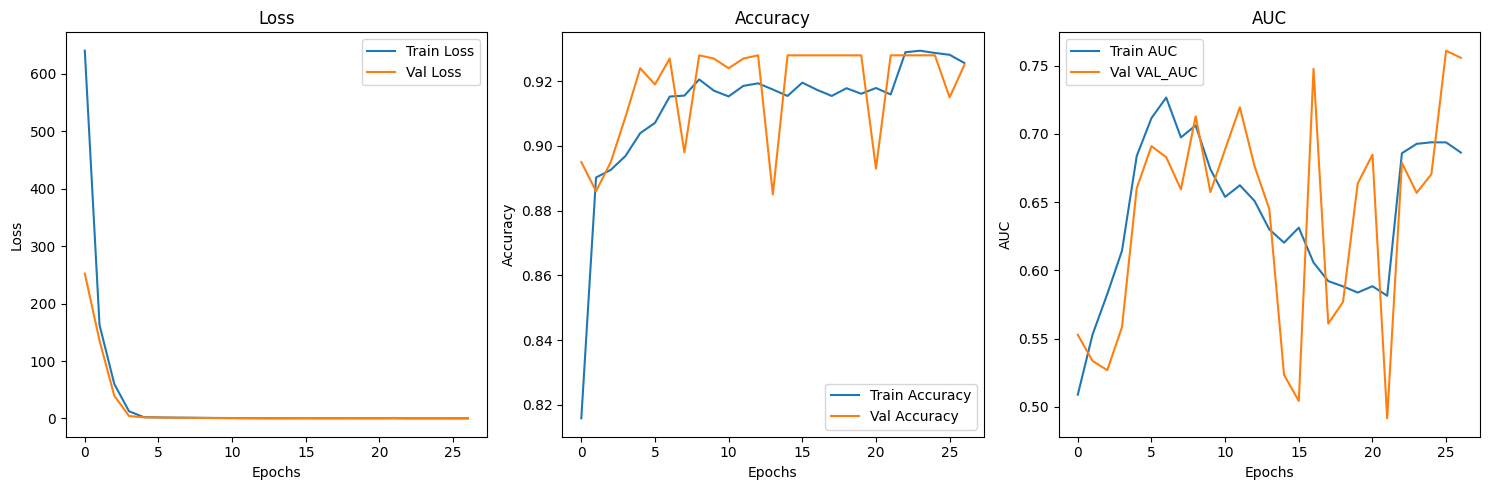

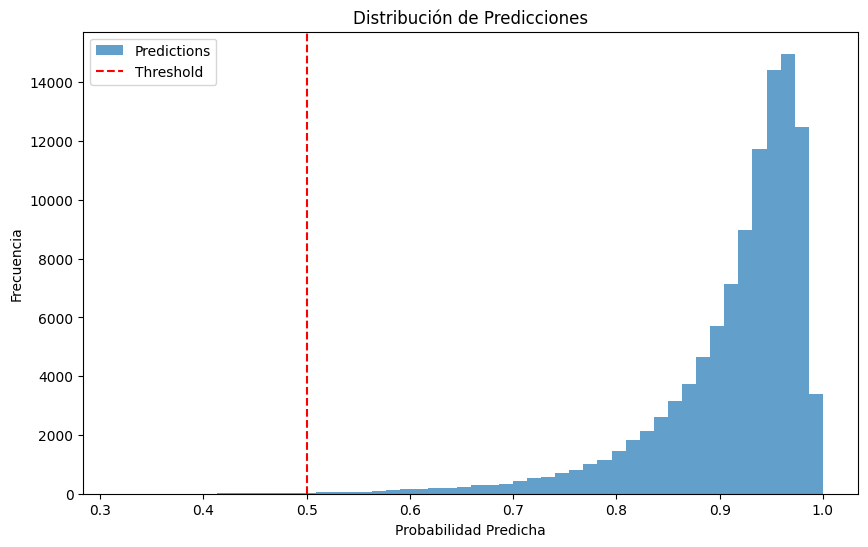


📋 Métricas disponibles en el historial:
  - AUC: 27 epochs
  - accuracy: 27 epochs
  - loss: 27 epochs
  - val_AUC: 27 epochs
  - val_accuracy: 27 epochs
  - val_loss: 27 epochs
  - learning_rate: 27 epochs


In [11]:
# Evaluar el modelo
print("📊 Evaluando modelo...")
results = deepfm.evaluate(X_test.values, y_test.values)

print(f"✅ Resultados de evaluación:")
print(f"AUC: {results['auc']:.4f}")
print(f"Accuracy: {results['accuracy']:.4f}")

# Visualizar curvas de entrenamiento
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
# Verificar qué métricas AUC están disponibles
auc_keys = [k for k in history.history.keys() if "auc" in k.lower()]
if auc_keys:
    for key in auc_keys:
        if "val" not in key:
            plt.plot(history.history[key], label=f"Train {key.upper()}")
        else:
            plt.plot(history.history[key], label=f"Val {key.upper()}")
    plt.title("AUC")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.legend()
else:
    plt.text(
        0.5,
        0.5,
        "AUC metrics not available\nin training history",
        horizontalalignment="center",
        verticalalignment="center",
        transform=plt.gca().transAxes,
    )
    plt.title("AUC (Not Available)")

plt.tight_layout()
plt.show()

# Distribución de predicciones
plt.figure(figsize=(10, 6))
plt.hist(results["predictions"], bins=50, alpha=0.7, label="Predictions")
plt.axvline(x=0.5, color="red", linestyle="--", label="Threshold")
plt.title("Distribución de Predicciones")
plt.xlabel("Probabilidad Predicha")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# Mostrar métricas disponibles en el historial
print("\n📋 Métricas disponibles en el historial:")
for key in history.history.keys():
    print(f"  - {key}: {len(history.history[key])} epochs")

## 5. Sistema de Recomendación

In [12]:
class FoodcomRecommenderDeepFM:
    def __init__(self, deepfm_model, processor, df_recipes):
        self.model = deepfm_model
        self.processor = processor
        self.df_recipes = df_recipes

    def recommend_for_user(self, user_id, top_k=10, exclude_seen=True):
        """Generar recomendaciones para un usuario específico"""

        # Verificar si el usuario existe en el encoder
        try:
            user_encoded = self.processor.user_encoder.transform([user_id])[0]
        except ValueError:
            print(f"Usuario {user_id} no encontrado en el dataset de entrenamiento")
            return pd.DataFrame()

        # Obtener todos los items disponibles
        all_items = self.processor.item_encoder.classes_

        # Crear features para todas las combinaciones usuario-item
        recommendations_data = []

        for item_id in all_items:
            # Obtener metadata del item
            recipe_info = self.df_recipes[self.df_recipes["item_id"] == item_id]

            if len(recipe_info) == 0:
                continue

            recipe_info = recipe_info.iloc[0]

            # Encoded values
            item_encoded = self.processor.item_encoder.transform([item_id])[0]
            category = recipe_info.get("recipe_category", "unknown")

            try:
                category_encoded = self.processor.category_encoder.transform(
                    [category]
                )[0]
            except ValueError:
                category_encoded = self.processor.category_encoder.transform(
                    ["unknown"]
                )[0]

            # Features numéricas en el orden correcto que espera el modelo
            numeric_values = []
            for feature_name in self.processor.numeric_features:
                value = recipe_info.get(feature_name, 0)
                numeric_values.append(value)
            
            # Normalizar usando el scaler entrenado
            numeric_features = np.array([numeric_values])
            try:
                numeric_features_scaled = self.processor.numeric_scaler.transform(
                    numeric_features
                )[0]
            except Exception as e:
                print(f"Warning: Error normalizing features for item {item_id}: {e}")
                numeric_features_scaled = [0] * len(self.processor.numeric_features)

            # Features derivadas - usar SOLO las mismas que en entrenamiento
            # Según el procesador: ["high_rating", "high_protein", "low_fat"]
            aggregated_rating_idx = self.processor.numeric_features.index("aggregated_rating")
            protein_content_idx = self.processor.numeric_features.index("protein_content") 
            fat_content_idx = self.processor.numeric_features.index("fat_content")
            
            high_rating = int(numeric_features_scaled[aggregated_rating_idx] > 0)
            high_protein = int(numeric_features_scaled[protein_content_idx] > 0.5)
            low_fat = int(numeric_features_scaled[fat_content_idx] < -0.5)

            # Crear feature vector en el orden exacto del entrenamiento:
            # categorical_features + numerical_features + derived_features
            feature_vector = (
                [user_encoded, item_encoded, category_encoded] +  # categorical
                list(numeric_features_scaled) +  # numerical (9 features)
                [high_rating, high_protein, low_fat]  # derived (3 features)
            )

            recommendations_data.append(
                {
                    "item_id": item_id,
                    "image_url": recipe_info.get("image_url", ""),
                    "features": feature_vector,
                    "recipe_name": recipe_info.get("name", "Unknown"),
                    "category": category,
                    "calories": recipe_info.get("calories", 0),
                    "rating": recipe_info.get("aggregated_rating", 0),
                }
            )

        if not recommendations_data:
            return pd.DataFrame()

        # Preparar matriz de features
        feature_matrix = np.array([item["features"] for item in recommendations_data])

        # Hacer predicciones
        scores = self.model.predict(feature_matrix).flatten()

        # Crear DataFrame con resultados
        results_df = pd.DataFrame(recommendations_data)
        results_df["score"] = scores

        # Ordenar por score descendente
        results_df = results_df.sort_values("score", ascending=False)

        # Retornar top K recomendaciones
        top_recommendations = results_df.head(top_k)[
            ["item_id", "image_url", "recipe_name", "category", "calories", "rating", "score"]
        ]

        return top_recommendations

    def get_user_statistics(self, user_id):
        """Obtener estadísticas del usuario"""
        # Esta función podría expandirse para mostrar el historial del usuario
        try:
            user_encoded = self.processor.user_encoder.transform([user_id])[0]
            return (
                f"Usuario {user_id} (encoded: {user_encoded}) encontrado en el sistema"
            )
        except ValueError:
            return f"Usuario {user_id} no encontrado en el dataset de entrenamiento"


# Crear sistema de recomendación
recommender = FoodcomRecommenderDeepFM(deepfm, processor, df_recipes)
print("✅ Sistema de recomendación creado")

✅ Sistema de recomendación creado


## 6. Demostración del Sistema de Recomendación

🔍 Recomendaciones para el usuario: 464080
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


,ID Receta,Nombre de la Receta,Categoría,Calorías,Rating,Score Modelo
1088,148446,Seasoned Goldfish Crackers,Toddler Friendly,30933.4,5.0,1.0000
1405,224374,The Garbage Plate (Burger Version),Potato,3020.9,4.5,1.0000
2260,524867,Layered Ragu Taco Salad With Crispy Tortilla T...,Sauces,999.5,5.0,0.9995
1833,338902,Peanut Butter Cookies Without Butter,Dessert,4210.0,5.0,0.9993
737,85332,Corned Beef (Corn Your Own),Meat,846.8,5.0,0.9992
2125,428343,Granny's Greek Fried Potatoes,Potato,2202.0,5.0,0.9989
442,39709,Crock Pot BBQ Smothered Chicken,Whole Chicken,2307.8,5.0,0.9982
1426,235300,Santa Anna's Black Bean Casserole - Authentic ...,One Dish Meal,615.6,5.0,0.9972
2082,412158,Applebee's Style 3 Cheese Chicken Penne,One Dish Meal,1332.4,5.0,0.9972
996,133993,Tourtiere (French Canadian Meat Pie),Savory Pies,1862.8,5.0,0.9970


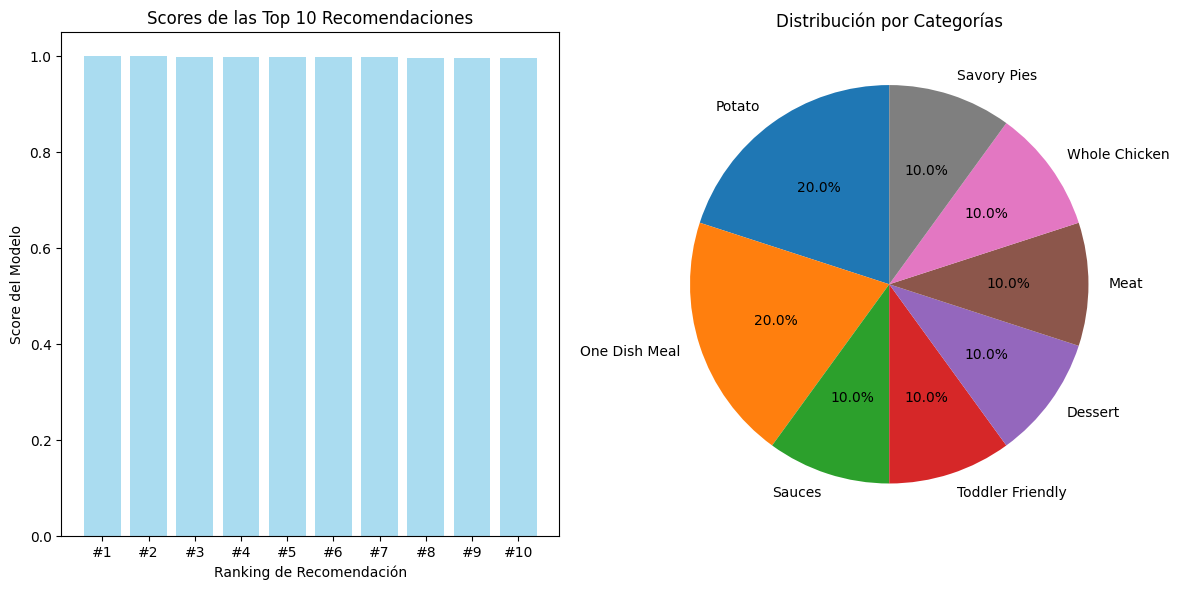


💡 INSIGHTS:
• La receta con mayor score es: 'Seasoned Goldfish Crackers' (Score: 1.0000)
• La categoría más recomendada es: 'Potato' (2 recetas)
• Rango de calorías: 616 - 30933
• Todas las recomendaciones tienen un score > 0.9970


In [13]:
# Mostrar las recomendaciones en formato de tabla más limpio
example_user_id = df_reviews['user_id'].sample(1).values[0]
print(f"🔍 Recomendaciones para el usuario: {example_user_id}")
recommendations = recommender.recommend_for_user(
    user_id=example_user_id, 
    top_k=10, 
    exclude_seen=True
)
display_recommendations = recommendations.copy()
display_recommendations['score'] = display_recommendations['score'].round(4)
display_recommendations['calories'] = display_recommendations['calories'].round(1)
display_recommendations['rating'] = display_recommendations['rating'].round(2)

# Renombrar columnas para mejor visualización
display_recommendations = display_recommendations.rename(columns={
    'item_id': 'ID Receta',
    'recipe_name': 'Nombre de la Receta',
    'category': 'Categoría',
    'calories': 'Calorías',
    'rating': 'Rating',
    'score': 'Score Modelo'
})

# Seleccionar solo las columnas más importantes para mostrar
display_cols = ['ID Receta', 'Nombre de la Receta', 'Categoría', 'Calorías', 'Rating', 'Score Modelo']

display(display_recommendations[display_cols])

# Crear visualización de los scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(recommendations)), recommendations['score'], color='skyblue', alpha=0.7)
plt.xlabel('Ranking de Recomendación')
plt.ylabel('Score del Modelo')
plt.title('Scores de las Top 10 Recomendaciones')
plt.xticks(range(len(recommendations)), [f'#{i+1}' for i in range(len(recommendations))])

plt.subplot(1, 2, 2)
category_counts = recommendations['category'].value_counts()
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución por Categorías')

plt.tight_layout()
plt.show()

print(f"\n💡 INSIGHTS:")
print(f"• La receta con mayor score es: '{recommendations.iloc[0]['recipe_name']}' (Score: {recommendations.iloc[0]['score']:.4f})")
print(f"• La categoría más recomendada es: '{category_counts.index[0]}' ({category_counts.iloc[0]} recetas)")
print(f"• Rango de calorías: {recommendations['calories'].min():.0f} - {recommendations['calories'].max():.0f}")
print(f"• Todas las recomendaciones tienen un score > {recommendations['score'].min():.4f}")